## Imports

In [75]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [76]:
from data_processing import get_clustered_data_with_bus_only, get_numeric_name, split_into_lines, get_train_and_test_by_lines, get_train_and_test_for_lines

In [77]:
df = get_clustered_data_with_bus_only('./data/SZP-2021-09-03.csv')

Amount of invalid data: 2


In [78]:
df = get_numeric_name(df, "Nazwa przystanku", drop=True)

In [79]:
df.sample(5)

,Nr linii,Wariant linii,Kurs,Oznaczenie brygady,Numer taborowy,Numer przystanku,Rzeczywisty czas odjazdu,Rozkładowy czas odjazdu,Liczba pasaz. przed,Liczba wysiadających pasaz.,Liczba wsiadajacych pasaz.,Liczba pasaz. po odjezdzie,Godzina odjazdu,Godzina odjazdu przedział,class,Numeryczna Nazwa przystanku
122117,239,TP-KRA,2022-01-29 18:59:00,57,9245,1,2022-01-29 19:07:00,2022-01-29 19:08:00,4,1,0,3,19.133333,76,0,1148
4075,103,TO-MML,2022-01-29 08:48:00,5,9442,1,2022-01-29 09:21:00,2022-01-29 09:21:00,6,3,3,6,9.350000,37,0,281
86191,194,TP-CMW,2022-01-29 09:46:00,4,9558,2,2022-01-29 09:51:00,2022-01-29 09:53:00,4,0,0,4,9.883333,39,0,941
24391,135,TO-HAL,2022-01-29 14:10:00,3,9317,1,2022-01-29 14:11:00,2022-01-29 14:11:00,7,0,2,9,14.183333,56,0,414
75091,186,TP-NWD,2022-01-29 16:05:00,6,9917,1,2022-01-29 16:08:00,2022-01-29 16:28:00,5,0,0,5,16.466667,65,0,58


In [80]:
lines = split_into_lines(df, drop_line = True)

C:\Users\Patryk\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


## Classification

In [81]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
import datetime as dt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from mlxtend.evaluate import bootstrap_point632_score
from mlxtend.evaluate import BootstrapOutOfBag
from mlxtend.evaluate import bootstrap

import seaborn as sns
import matplotlib.pyplot as plt

In [83]:
features = ['Numer taborowy', 'Godzina odjazdu', 'Godzina odjazdu przedział', 'Numeryczna Nazwa przystanku']
labels = ["class"]

In [84]:
data_lines = dict()
for key, value in lines.items():
    data_lines[key] = get_train_and_test_for_lines(value, X_columns = features, y_columns = labels)

### DecisionTreeClassifier

In [85]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [86]:
model = DecisionTreeClassifier(max_depth = 1000, random_state = 1)

In [87]:
#LeaveOneOut CrossValidation with negative mean absolute scores: the higher the scores, the lower mean absolute errors
# scores1 = cross_validate(model, X_train, y_train, cv = LeaveOneOut(), n_jobs = -1, scoring = 'neg_mean_absolute_error', return_estimator = True)
# err1 = accuracy_score(scores1['estimator'][scores1['test_score'].argmax()].predict(X_test),y_test)

In [88]:
#Bootstrap Out of Bag
predicted = np.array([])
y_tests = np.array([])
for value in data_lines.values():
    X_train, X_test, y_train, y_test = value
    scores2 = cross_validate(model, X_train, y_train, cv = BootstrapOutOfBag(n_splits=5, random_seed=456), n_jobs = -1, return_estimator = True)

    predicted = np.concatenate((predicted, scores2['estimator'][scores2['test_score'].argmax()].predict(X_test)), axis=0)
    y_tests = np.concatenate((y_tests, y_test.to_numpy().reshape(1,-1)[0]), axis=0)
err2 = accuracy_score(predicted, y_tests)

In [89]:
#Repeated K-Fold
predicted = np.array([])
y_tests = np.array([])
for value in data_lines.values():
    X_train, X_test, y_train, y_test = value
    scores3 = cross_validate(model, X_train, y_train, n_jobs = -1, cv = RepeatedKFold(n_splits = 10, n_repeats = 2), return_estimator = True)

    predicted = np.concatenate((predicted, scores3['estimator'][scores3['test_score'].argmax()].predict(X_test)), axis=0)
    y_tests = np.concatenate((y_tests, y_test.to_numpy().reshape(1,-1)[0]), axis=0)
err3 = accuracy_score(predicted, y_tests)

In [90]:
#K-Fold
predicted = np.array([])
y_tests = np.array([])
for value in data_lines.values():
    X_train, X_test, y_train, y_test = value
    scores4 = cross_validate(model, X_train, y_train, cv = KFold(10), n_jobs=-1, return_estimator = True)

    predicted = np.concatenate((predicted, scores4['estimator'][scores4['test_score'].argmax()].predict(X_test)), axis=0)
    y_tests = np.concatenate((y_tests, y_test.to_numpy().reshape(1,-1)[0]), axis=0)
err4 = accuracy_score(predicted, y_tests)

In [91]:
print("------- Accuracy --------")
# print(f"1. Accuracy LeaveOneOut {err1}")
print(f"2. Accuracy BootstrapOutOfBag {err2}")
print(f"3. Accuracy RepeatedKFold {err3}")
print(f"4. Accuracy KFold {err4}")

------- Accuracy --------
2. Accuracy BootstrapOutOfBag 0.7683629982451742
3. Accuracy RepeatedKFold 0.7919278014539985
4. Accuracy KFold 0.7969415893707696


### RandomForestClassifier

In [92]:
from sklearn.ensemble import RandomForestClassifier

In [93]:
model = RandomForestClassifier(max_depth = 1000, random_state = 1)

In [94]:
#Bootstrap Out of Bag
predicted = np.array([])
y_tests = np.array([])
for value in data_lines.values():
    X_train, X_test, y_train, y_test = value
    scores2 = cross_validate(model, X_train, y_train, cv = BootstrapOutOfBag(n_splits=5, random_seed=456), n_jobs = -1, return_estimator = True)

    predicted = np.concatenate((predicted, scores2['estimator'][scores2['test_score'].argmax()].predict(X_test)), axis=0)
    y_tests = np.concatenate((y_tests, y_test.to_numpy().reshape(1,-1)[0]), axis=0)
err2 = accuracy_score(predicted, y_tests)

In [95]:
#Repeated K-Fold
predicted = np.array([])
y_tests = np.array([])
for value in data_lines.values():
    X_train, X_test, y_train, y_test = value
    scores3 = cross_validate(model, X_train, y_train, n_jobs = -1, cv = RepeatedKFold(n_splits = 10, n_repeats = 2), return_estimator = True)

    predicted = np.concatenate((predicted, scores3['estimator'][scores3['test_score'].argmax()].predict(X_test)), axis=0)
    y_tests = np.concatenate((y_tests, y_test.to_numpy().reshape(1,-1)[0]), axis=0)
err3 = accuracy_score(predicted, y_tests)

In [96]:
#K-Fold
predicted = np.array([])
y_tests = np.array([])
for value in data_lines.values():
    X_train, X_test, y_train, y_test = value
    scores4 = cross_validate(model, X_train, y_train, cv = KFold(10), n_jobs=-1, return_estimator = True)

    predicted = np.concatenate((predicted, scores4['estimator'][scores4['test_score'].argmax()].predict(X_test)), axis=0)
    y_tests = np.concatenate((y_tests, y_test.to_numpy().reshape(1,-1)[0]), axis=0)
err4 = accuracy_score(predicted, y_tests)

In [97]:
print("------- Accuracy --------")
# print(f"1. Accuracy LeaveOneOut {err1}")
print(f"2. Accuracy BootstrapOutOfBag {err2}")
print(f"3. Accuracy RepeatedKFold {err3}")
print(f"4. Accuracy KFold {err4}")

------- Accuracy --------
2. Accuracy BootstrapOutOfBag 0.8042115818500878
3. Accuracy RepeatedKFold 0.8305339684131361
4. Accuracy KFold 0.8297819002256205


### RUSBoostClassifier

In [99]:
from imblearn.ensemble import RUSBoostClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score

In [102]:
predicted = np.array([])
y_tests = np.array([])
for value in data_lines.values():
    X_train, X_test, y_train, y_test = value
    rusboost = RUSBoostClassifier(n_estimators=50, base_estimator = DecisionTreeClassifier(max_depth = 1000, random_state = 1), algorithm='SAMME', random_state=1)
    rusboost.fit(X_train, y_train)

    predicted = np.concatenate((predicted, rusboost.predict(X_test)), axis=0)
    y_tests = np.concatenate((y_tests, y_test.to_numpy().reshape(1,-1)[0]), axis=0)
print("Resampled accuracy: {:.2f}".format(accuracy_score(y_tests, predicted)))
print("Resampled balanced accuracy: {:.2f}".format(balanced_accuracy_score(y_tests, predicted)))

C:\Users\Patryk\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Patryk\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RUSBoostClassifier was fitted with feature names
  warnings.warn(
C:\Users\Patryk\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Patryk\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RUSBoostClassifier was fitted with feature names

Resampled accuracy: 0.65
Resampled balanced accuracy: 0.70


C:\Users\Patryk\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RUSBoostClassifier was fitted with feature names
  warnings.warn(
C:\Users\Patryk\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Patryk\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RUSBoostClassifier was fitted with feature names
  warnings.warn(
C:\Users\Patryk\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or

In [103]:
predicted = np.array([])
y_tests = np.array([])
for value in data_lines.values():
    X_train, X_test, y_train, y_test = value
    rusboost = RUSBoostClassifier(n_estimators=50, base_estimator = RandomForestClassifier(max_depth = 1000, random_state = 1), algorithm='SAMME', random_state=1)
    rusboost.fit(X_train, y_train)

    predicted = np.concatenate((predicted, rusboost.predict(X_test)), axis=0)
    y_tests = np.concatenate((y_tests, y_test.to_numpy().reshape(1,-1)[0]), axis=0)
print("Resampled accuracy: {:.2f}".format(accuracy_score(y_tests, predicted)))
print("Resampled balanced accuracy: {:.2f}".format(balanced_accuracy_score(y_tests, predicted)))

C:\Users\Patryk\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Patryk\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RUSBoostClassifier was fitted with feature names
  warnings.warn(
C:\Users\Patryk\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Patryk\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RUSBoostClassifier was fitted with feature names

Resampled accuracy: 0.66
Resampled balanced accuracy: 0.72


C:\Users\Patryk\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RUSBoostClassifier was fitted with feature names
  warnings.warn(


## Regresja

In [104]:
features = ['Numer taborowy', 'Godzina odjazdu', 'Godzina odjazdu przedział', 'Numeryczna Nazwa przystanku']
labels = ["Liczba pasaz. przed"]

In [105]:
data_lines = dict()
for key, value in lines.items():
    data_lines[key] = get_train_and_test_for_lines(value, X_columns = features, y_columns = labels)

### DecisionTreeRegressor

In [108]:
from sklearn.tree import DecisionTreeRegressor

In [109]:
model = DecisionTreeRegressor(max_depth = 1000, random_state = 1)

In [113]:
#Bootstrap Out of Bag
predicted = np.array([])
y_tests = np.array([])
for value in data_lines.values():
    X_train, X_test, y_train, y_test = value
    scores2 = cross_validate(model, X_train, y_train, cv = BootstrapOutOfBag(n_splits=5, random_seed=456), n_jobs = -1, return_estimator = True)

    predicted = np.concatenate((predicted, scores2['estimator'][scores2['test_score'].argmax()].predict(X_test)), axis=0)
    y_tests = np.concatenate((y_tests, y_test.to_numpy().reshape(1,-1)[0]), axis=0)
err2 = abs(predicted - y_tests)

In [124]:
#Repeated K-Fold
predicted = np.array([])
y_tests = np.array([])
for value in data_lines.values():
    X_train, X_test, y_train, y_test = value
    scores3 = cross_validate(model, X_train, y_train, n_jobs = -1, cv = RepeatedKFold(n_splits = 10, n_repeats = 2), return_estimator = True)

    predicted = np.concatenate((predicted, scores3['estimator'][scores3['test_score'].argmax()].predict(X_test)), axis=0)
    y_tests = np.concatenate((y_tests, y_test.to_numpy().reshape(1,-1)[0]), axis=0)
err3 = abs(predicted - y_tests)

In [125]:
#K-Fold
predicted = np.array([])
y_tests = np.array([])
for value in data_lines.values():
    X_train, X_test, y_train, y_test = value
    scores4 = cross_validate(model, X_train, y_train, cv = KFold(10), n_jobs=-1, return_estimator = True)

    predicted = np.concatenate((predicted, scores4['estimator'][scores4['test_score'].argmax()].predict(X_test)), axis=0)
    y_tests = np.concatenate((y_tests, y_test.to_numpy().reshape(1,-1)[0]), axis=0)
err4 = abs(predicted - y_tests)

In [126]:
d_err = []
d_err = pd.DataFrame({'Err':err2.reshape(-1), 'Type': 'BootOOB'})
d_err = d_err.append(pd.DataFrame({'Err':err3.reshape(-1), 'Type': 'Repeated KFold'}),ignore_index=True)
d_err = d_err.append(pd.DataFrame({'Err':err4.reshape(-1), 'Type': 'KFold'}),ignore_index=True)

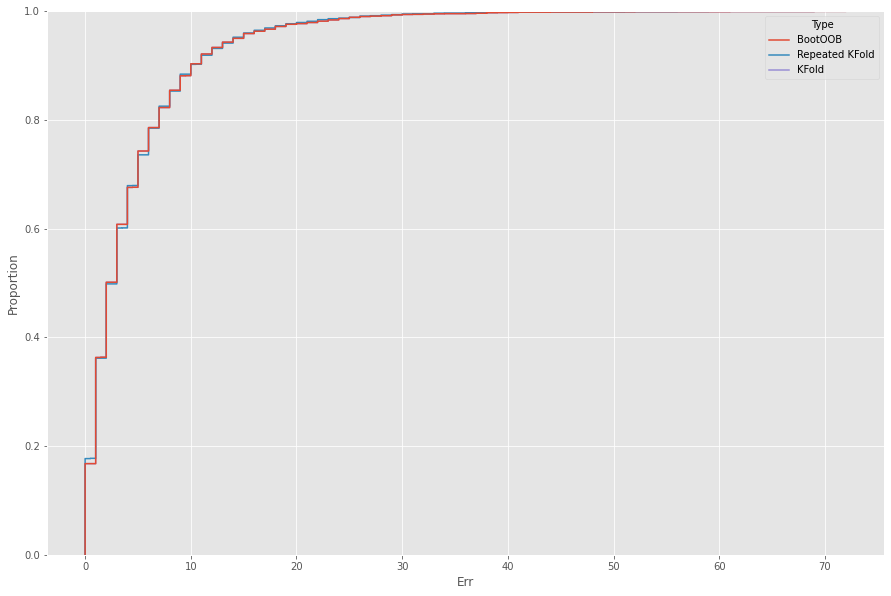

In [127]:
plt.figure(figsize = (15,10))
g = sns.ecdfplot(d_err, x = "Err", hue = 'Type')
#g.set(xlim = (0, 10))

In [128]:
stats = d_err.groupby('Type').describe().round(2)
stats

Err                                      
                 count  mean   std  min  25%  50%  75%   max
Type                                                        
BootOOB         3989.0  4.32  5.65  0.0  1.0  2.0  6.0  72.0
KFold           3989.0  4.32  5.65  0.0  1.0  2.0  6.0  72.0
Repeated KFold  3989.0  4.29  5.48  0.0  1.0  3.0  6.0  69.0

### RandomForestRegressor

In [129]:
from sklearn.ensemble import RandomForestRegressor

In [130]:
model = RandomForestRegressor(max_depth = 1000, random_state = 1)

In [131]:
#Bootstrap Out of Bag
predicted = np.array([])
y_tests = np.array([])
for value in data_lines.values():
    X_train, X_test, y_train, y_test = value
    scores2 = cross_validate(model, X_train, y_train, cv = BootstrapOutOfBag(n_splits=5, random_seed=456), n_jobs = -1, return_estimator = True)

    predicted = np.concatenate((predicted, scores2['estimator'][scores2['test_score'].argmax()].predict(X_test)), axis=0)
    y_tests = np.concatenate((y_tests, y_test.to_numpy().reshape(1,-1)[0]), axis=0)
err2 = abs(predicted - y_tests)

In [132]:
#Repeated K-Fold
predicted = np.array([])
y_tests = np.array([])
for value in data_lines.values():
    X_train, X_test, y_train, y_test = value
    scores3 = cross_validate(model, X_train, y_train, n_jobs = -1, cv = RepeatedKFold(n_splits = 10, n_repeats = 2), return_estimator = True)

    predicted = np.concatenate((predicted, scores3['estimator'][scores3['test_score'].argmax()].predict(X_test)), axis=0)
    y_tests = np.concatenate((y_tests, y_test.to_numpy().reshape(1,-1)[0]), axis=0)
err3 = abs(predicted - y_tests)

In [133]:
#K-Fold
predicted = np.array([])
y_tests = np.array([])
for value in data_lines.values():
    X_train, X_test, y_train, y_test = value
    scores4 = cross_validate(model, X_train, y_train, cv = KFold(10), n_jobs=-1, return_estimator = True)

    predicted = np.concatenate((predicted, scores4['estimator'][scores4['test_score'].argmax()].predict(X_test)), axis=0)
    y_tests = np.concatenate((y_tests, y_test.to_numpy().reshape(1,-1)[0]), axis=0)
err4 = abs(predicted - y_tests)

In [134]:
d_err = []
d_err = pd.DataFrame({'Err':err2.reshape(-1), 'Type': 'BootOOB'})
d_err = d_err.append(pd.DataFrame({'Err':err3.reshape(-1), 'Type': 'Repeated KFold'}),ignore_index=True)
d_err = d_err.append(pd.DataFrame({'Err':err4.reshape(-1), 'Type': 'KFold'}),ignore_index=True)

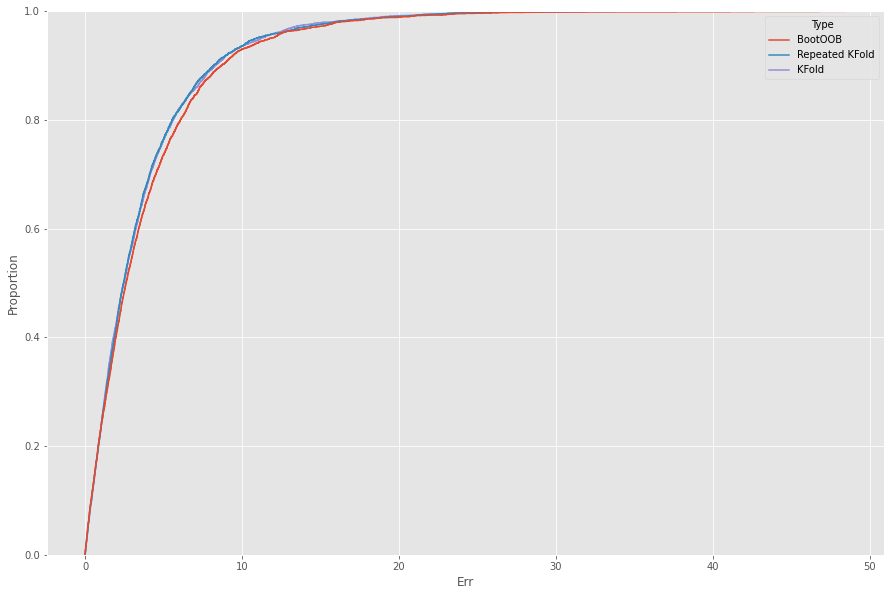

In [135]:
plt.figure(figsize = (15,10))
g = sns.ecdfplot(d_err, x = "Err", hue = 'Type')
#g.set(xlim = (0, 10))

In [136]:
stats = d_err.groupby('Type').describe().round(2)
stats

Err                                          
                 count  mean   std  min   25%   50%   75%    max
Type                                                            
BootOOB         3989.0  3.87  4.22  0.0  1.10  2.61  5.22  48.48
KFold           3989.0  3.64  3.87  0.0  1.06  2.47  4.81  34.07
Repeated KFold  3989.0  3.63  3.90  0.0  1.08  2.45  4.78  31.47